## Cleaning and standardizing the data

In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import glob
import os
import numpy as np
from rapidfuzz import process, fuzz
import re

In [ ]:
path = "/content/drive/MyDrive/hotfoot/Dataset/Entity-wise UPIIMPSNETCNFSAePSCTSBBPS Statistics/monthly entity data.xlsx"
output = "/content/Monthly_entitywise.xlsx"

In [ ]:
os.makedirs(output, exist_ok=True)

excel_data = pd.read_excel(path, sheet_name=None, header=[0, 1])

def rename_columns(multi_cols):
    new_cols = []

    for idx, (lev1, lev2) in enumerate(multi_cols):
        lev1 = str(lev1).lower()
        lev2 = str(lev2).lower()

        if "remitter" in lev1 and "volume" in lev2:
            new_cols.append("remitter_volume")

        elif "remitter" in lev1 and "value" in lev2:
            new_cols.append("remitter_value")

        elif "beneficiary" in lev1 and "volume" in lev2:
            new_cols.append("beneficiary_volume")

        elif "beneficiary" in lev1 and "value" in lev2:
            new_cols.append("beneficiary_value")

        else:
            if idx == 2:
                new_cols.append("remitter_volume")
            elif idx == 3:
                new_cols.append("remitter_value")
            elif idx == 4:
                new_cols.append("beneficiary_volume")
            elif idx == 5:
                new_cols.append("beneficiary_value")
            else:
                new_cols.append(lev2)

    return new_cols


output_excel_file = os.path.join(output, "monthly_entitywise_data.xlsx")

with pd.ExcelWriter(output_excel_file, engine="openpyxl") as writer:
    for sheet_name, df in excel_data.items():
        df.columns = rename_columns(df.columns)
        df = df.drop(index=[0])
        df.to_excel(writer, sheet_name=sheet_name, index=False)



## Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Concatinating all into one master csv

In [ ]:
excel_data = pd.read_excel("/content/drive/MyDrive/hotfoot/Dataset/Entity-wise UPI Statistics/monthly_UPI_entitywise_data.xlsx", sheet_name=None)
bank_col = "entity name"

dfs = []
for sheet_name, df in excel_data.items():
  df= df.copy()
  df["month_year"] = sheet_name
  dfs.append(df)
data = pd.concat(dfs, ignore_index = True)
print(data.info())


print(data.columns.tolist())
data.to_csv("master_bank_monthly_data.csv", index=False)

print(data.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13238 entries, 0 to 13237
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sr. no.             13219 non-null  float64
 1   entity name         11687 non-null  object 
 2   remitter_volume     13238 non-null  float64
 3   remitter_value      13238 non-null  float64
 4   beneficiary_volume  13238 non-null  float64
 5   beneficiary_value   13238 non-null  float64
 6   month_year          13238 non-null  object 
 7    bank name          1551 non-null   object 
dtypes: float64(5), object(3)
memory usage: 827.5+ KB
None
['sr. no.', 'entity name', 'remitter_volume', 'remitter_value', 'beneficiary_volume', 'beneficiary_value', 'month_year', ' bank name']
   sr. no.           entity name  remitter_volume  remitter_value  \
0      1.0   State Bank of India      33698.57068   522071.798614   
1      2.0             HDFC Bank      11336.35917   215518.201253   
2

In [ ]:
# Monthly-wise master data -> extracted from all 19 months of only UPI transaction

df = pd.read_csv("/content/drive/MyDrive/hotfoot/Dataset/Entity-wise UPI Statistics/upi_master_19_months_entity_cleaned.csv")


df["month_year"] = pd.to_datetime(df["month_year"], format="%B_%Y")
df["entity name"] = df["entity name"].str.lower()
num_cols = [
    "remitter_volume", "remitter_value",
    "beneficiary_volume", "beneficiary_value"
]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13219 entries, 0 to 13218
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   sr. no.             13219 non-null  int64         
 1   entity name         13218 non-null  object        
 2   remitter_volume     13219 non-null  float64       
 3   remitter_value      13219 non-null  float64       
 4   beneficiary_volume  13219 non-null  float64       
 5   beneficiary_value   13219 non-null  float64       
 6   month_year          13219 non-null  datetime64[ns]
 7   bank name           0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 826.3+ KB


### Market Share and Bank dominance
* total remitter value by bank -> TOP remitter -> Major sender of funds
* Total beneficiary value by bank -> Top beneficiary -> Major reciever

** identifies important banks among all

In [ ]:

market_share = (df.groupby("entity name")[["remitter_value", "beneficiary_value"]].sum().sort_values("remitter_value", ascending=False))

market_share["remitter_share_%"] = (market_share["remitter_value"] /market_share["remitter_value"].sum() * 100)

market_share["beneficiary_share_%"] = (market_share["beneficiary_value"] / market_share["beneficiary_value"].sum() * 100)

top_5_share = market_share["remitter_share_%"].head(5).sum()

market_share.to_csv("market_share.csv")


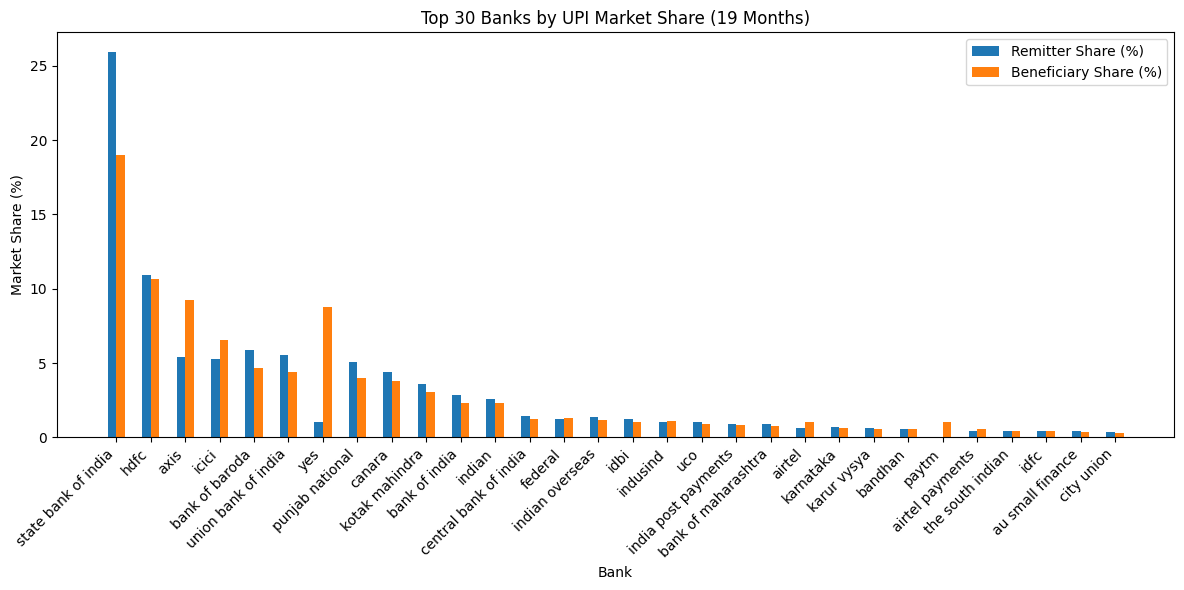

In [ ]:
top30 = market_share.assign(
    total_share = market_share["remitter_share_%"] + market_share["beneficiary_share_%"]).sort_values("total_share", ascending=False).head(30)

x = np.arange(len(top30))
width = 0.25

plt.figure(figsize=(12, 6))

plt.bar(x - width/2, top30["remitter_share_%"], width,label="Remitter Share (%)")

plt.bar(x + width/2, top30["beneficiary_share_%"], width, label="Beneficiary Share (%)")

plt.title("Top 30 Banks by UPI Market Share (19 Months)")
plt.xlabel("Bank")
plt.ylabel("Market Share (%)")

plt.xticks(x, top30.index, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


### Remitter vs Bebeficiary Imnalance (Net Flow)
* If beneficiary_value - Remitter_value > 0 -> **Net Reciever**
* If beneficiary_value - Remitter_value < 0 -> **Net Sender**

** Bank 'X' consistently recieves more value than it sends (vice-versa)

In [ ]:
net_flow = market_share.copy()
net_flow["net_flow_value"] = (net_flow["beneficiary_value"] - net_flow["remitter_value"] )

net_flow["flow_type"] = np.where(net_flow["net_flow_value"] > 0,"Net Receiver","Net Sender")

net_flow.to_csv("net_flow.csv")

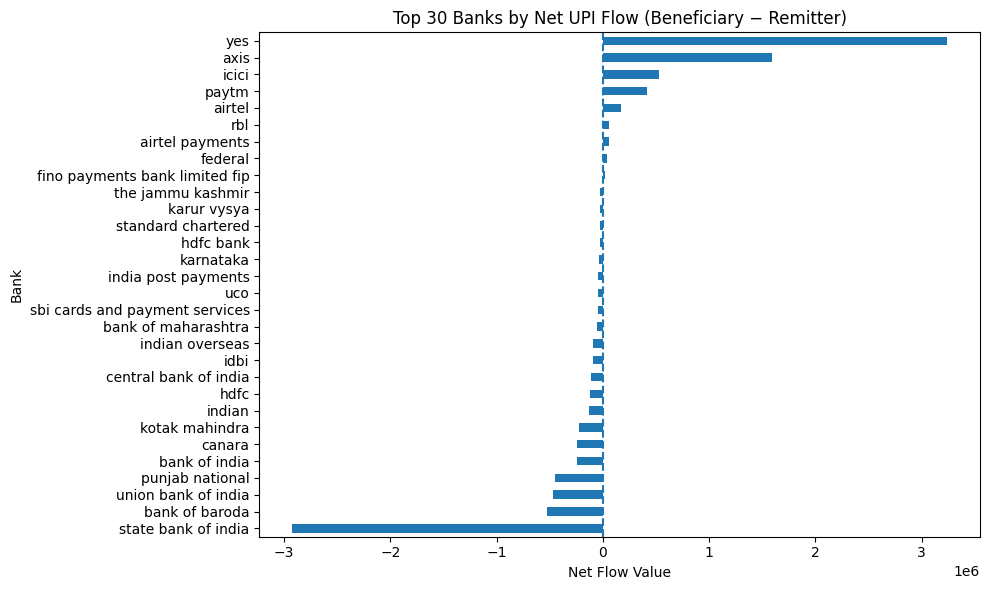

In [ ]:
import matplotlib.pyplot as plt

top_net_flow = net_flow.loc[net_flow["net_flow_value"].abs().sort_values(ascending=False).head(30).index]

plt.figure(figsize=(10, 6))
top_net_flow["net_flow_value"].sort_values().plot(kind="barh")

plt.axvline(0, linestyle="--")
plt.title("Top 30 Banks by Net UPI Flow (Beneficiary − Remitter)")
plt.xlabel("Net Flow Value")
plt.ylabel("Bank")

plt.tight_layout()
plt.show()


### Volume vs Value behaviour (Transaction size Insight)

** Avg Transaction size = Value / Volume
* High Value + Low Volume -> Large Corporate Transaction
* Low Value + High Volume -> Retail or UPI heavy usage

In [ ]:
txn_size = (df.groupby("entity name")[num_cols].sum())

txn_size["avg_remitter_ticket"] = (txn_size["remitter_value"] / txn_size["remitter_volume"])

txn_size["avg_beneficiary_ticket"] = (txn_size["beneficiary_value"] / txn_size["beneficiary_volume"])

txn_size["total_volume"] = (txn_size["remitter_volume"] + txn_size["beneficiary_volume"])

txn_size["avg_ticket"] = (txn_size["avg_remitter_ticket"] +txn_size["avg_beneficiary_ticket"]) / 2

txn_size.to_csv("transaction_size.csv")

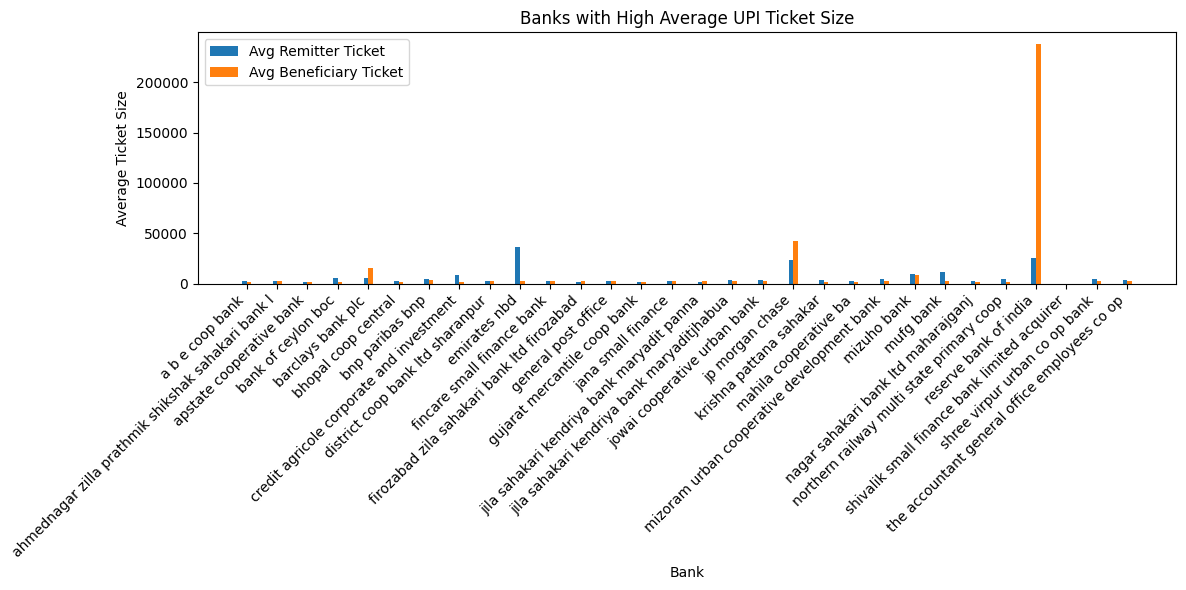

In [ ]:
threshold = txn_size[["avg_remitter_ticket", "avg_beneficiary_ticket"]].quantile(0.9)

top_banks = txn_size[(txn_size["avg_remitter_ticket"] >= threshold["avg_remitter_ticket"]) &
                     (txn_size["avg_beneficiary_ticket"] >= threshold["avg_beneficiary_ticket"])].head(30)

plot_df = top_banks[["avg_remitter_ticket", "avg_beneficiary_ticket"]]

x = np.arange(len(plot_df))
width = 0.15

plt.figure(figsize=(12, 6))

plt.bar(x - width/2,plot_df["avg_remitter_ticket"],width,label="Avg Remitter Ticket")

plt.bar(x + width/2,plot_df["avg_beneficiary_ticket"],width,label="Avg Beneficiary Ticket")

plt.title("Banks with High Average UPI Ticket Size")
plt.xlabel("Bank")
plt.ylabel("Average Ticket Size")

plt.xticks(x, plot_df.index, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

### Growth Trends over 19 months
* Month-of-Month Growth(MoM) = [Value(t) - Value(t-1)] / [Value(t-1)]

Since for Apr-2024 there is no previous month so Nan for it.

** Mom values for all of them spikes in Jan-2025 because of the end of financial year, also stays positive (with double digit) in Mar-2025.


In [ ]:
monthly_totals = (df.groupby("month_year")[num_cols].sum().sort_index())

monthly_growth_pct = monthly_totals.pct_change() * 100

overall_growth = ((monthly_totals.iloc[-1] - monthly_totals.iloc[0]) / monthly_totals.iloc[0] * 100)

monthly_growth_pct.to_csv("monthly_growth.csv")


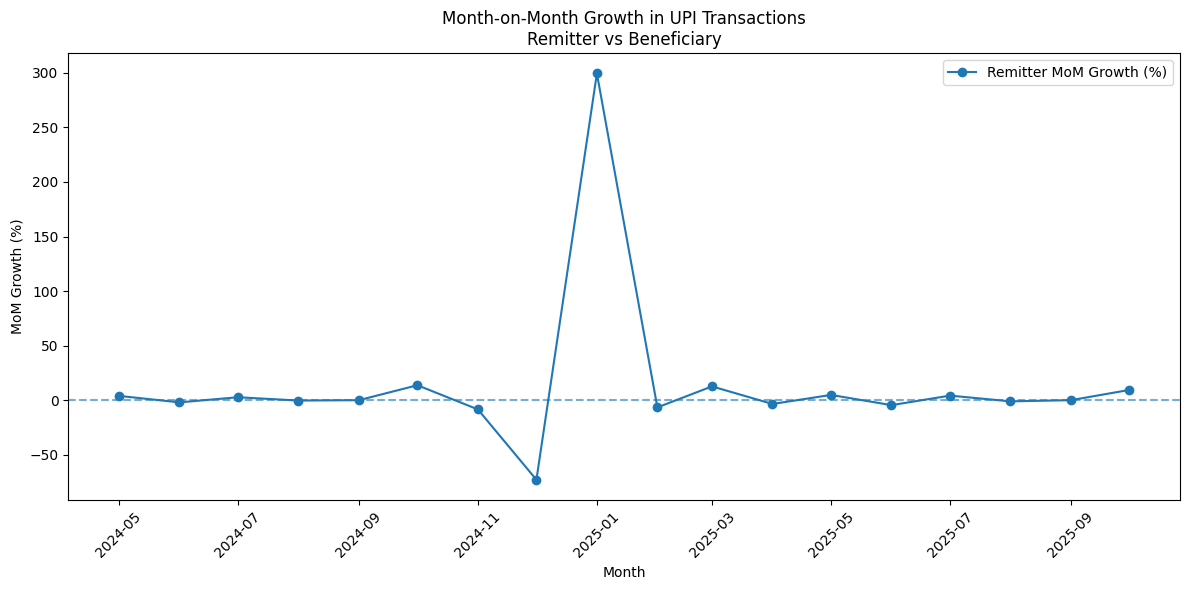

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(monthly_growth_pct.index,monthly_growth_pct["remitter_value"],marker="o",label="Remitter MoM Growth (%)")

plt.axhline(0, linestyle="--", alpha=0.6)

plt.title("Month-on-Month Growth in UPI Transactions\nRemitter")
plt.xlabel("Month")
plt.ylabel("MoM Growth (%)")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


###  SEASONALITY & CYCLIC PATTERNS
festive season transaction surge

In [ ]:
df["month"] = df["month_year"].dt.month

seasonality = (df.groupby("month")[["remitter_value", "beneficiary_value"]].agg(["mean", "std"]))

seasonality.to_csv("seasonality.csv")


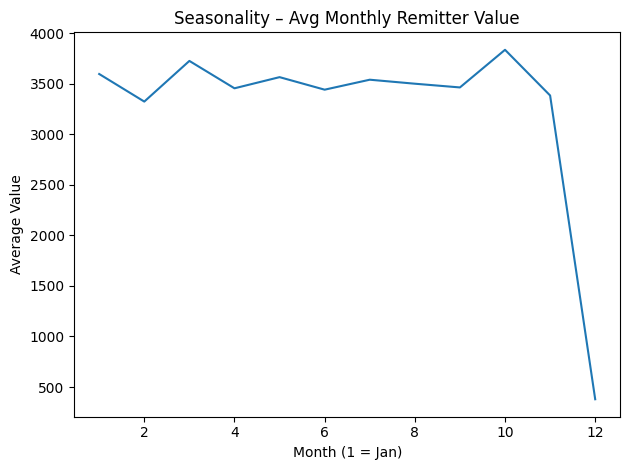

In [ ]:
seasonality["beneficiary_value"]["mean"].plot()
plt.title("Seasonality – Avg Monthly Remitter Value")
plt.xlabel("Month (1 = Jan)")
plt.ylabel("Average Value")
plt.tight_layout()
plt.show()


### Satbility and Volatility of Banks

In [ ]:
volatility = (df.groupby("entity name")[["remitter_value", "beneficiary_value"]].agg(["mean", "std"]))

volatility["remitter_cv"] = (volatility[("remitter_value", "std")] /volatility[("remitter_value", "mean")])

volatility["beneficiary_cv"] = (volatility[("beneficiary_value", "std")] / volatility[("beneficiary_value", "mean")])
volatility["avg_cv"] = (volatility["remitter_cv"] + volatility["beneficiary_cv"]) / 2

volatility.to_csv("stability_and_volatility.csv")


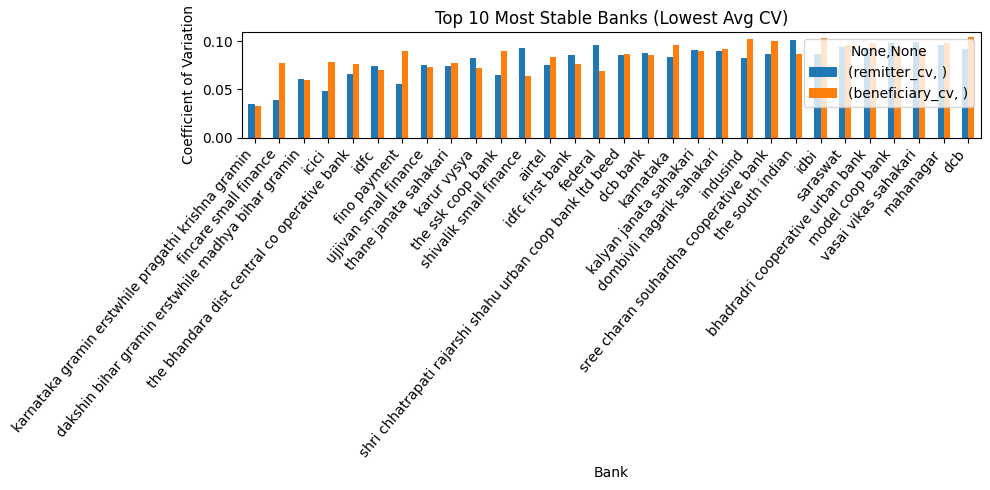

In [ ]:
volatility["avg_cv"] = (volatility["remitter_cv"] + volatility["beneficiary_cv"]) / 2

top_stable = volatility.sort_values("avg_cv").head(30)

top_stable[["remitter_cv", "beneficiary_cv"]].plot(kind="bar", figsize=(10,5))
plt.title("Top 10 Most Stable Banks (Lowest Avg CV)")
plt.xlabel("Bank")
plt.ylabel("Coefficient of Variation")
plt.xticks(rotation=50, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
bank_share = market_share["remitter_value"] / market_share["remitter_value"].sum()
HHI = np.sum(bank_share ** 2)
print("HHI (Herfindahl–Hirschman Index):", round(HHI, 4))

hhi_df = bank_share.reset_index()
hhi_df.columns = ["bank", "market_share"]

hhi_df["market_share_squared"] = hhi_df["market_share"] ** 2
hhi_df["HHI"] = HHI


hhi_df.to_csv("hhi_concentration.csv", index=False)

print(" HHI results")


HHI (Herfindahl–Hirschman Index): 0.1004
✅ HHI results exported to hhi_concentration_analysis.csv


In [ ]:
if HHI < 0.10:
    interpretation = "Highly competitive / low concentration, Healthy compitetion"
elif HHI >= 0.10 and HHI < 0.18:
    interpretation = "Moderately concentrated, need to Monitor"
elif HHI >= 0.18 and HHI < 0.25:
    interpretation = "Highly concentrated, Systemic relevance"
else:
    interpretation = "Very high systemic concentration risk"

print("HHI Interpretation:", interpretation)


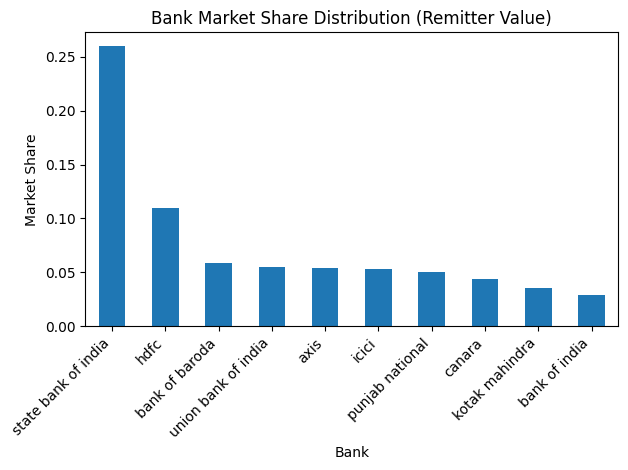

In [ ]:
bank_share.sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Bank Market Share Distribution (Remitter Value)")
plt.xlabel("Bank")
plt.ylabel("Market Share")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


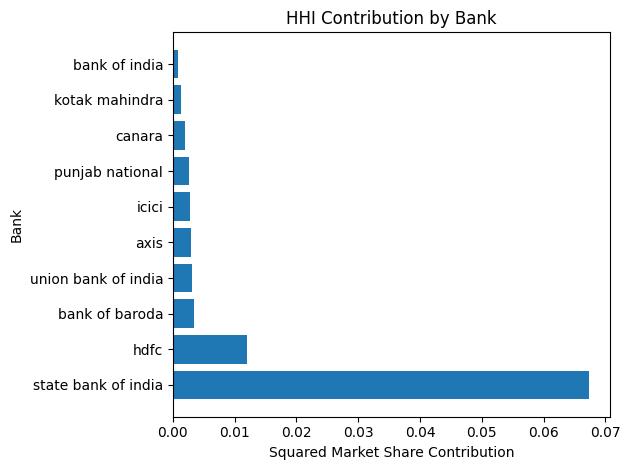

In [ ]:
hhi_df_sorted = hhi_df.sort_values("market_share_squared", ascending=False).head(10)

plt.barh(
    hhi_df_sorted["bank"],
    hhi_df_sorted["market_share_squared"]
)
plt.title("HHI Contribution by Bank")
plt.xlabel("Squared Market Share Contribution")
plt.ylabel("Bank")
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the correlation between remitter_value and beneficiary_value for each entity name
correlation_series = df.groupby("entity name").apply(lambda x: x["remitter_value"].corr(x["beneficiary_value"]))

corr_df = correlation_series.reset_index()
corr_df.columns = ["bank", "correlation"]

print(corr_df.head())

corr_df.to_csv("bank_remitter_beneficiary_correlation_interpreted.csv",index=False)


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


                                        bank  correlation
0                            a b e coop bank          NaN
1                 abhinandan urban coop bank          NaN
2        abhinandan urban coop bank amravati     0.996707
3  abhivriddhi mahila sahakara bank niyamita          NaN
4                                  abhyudaya     0.959968


/tmp/ipython-input-3046947535.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_series = df.groupby("entity name").apply(


In [ ]:
segmentation = txn_size.copy()

vol_median = segmentation["remitter_volume"].median()
val_median = segmentation["remitter_value"].median()

def classify(row):
    if row["remitter_volume"] >= vol_median and row["remitter_value"] < val_median:
        return "Retail Bank"
    elif row["remitter_volume"] < vol_median and row["remitter_value"] >= val_median:
        return "Corporate Bank"
    elif row["remitter_volume"] >= vol_median and row["remitter_value"] >= val_median:
        return "Universal Bank"
    else:
        return "Niche / Regional Bank"

segmentation["bank_segment"] = segmentation.apply(classify, axis=1)

segmentation.to_csv("bank_segmentation.csv")


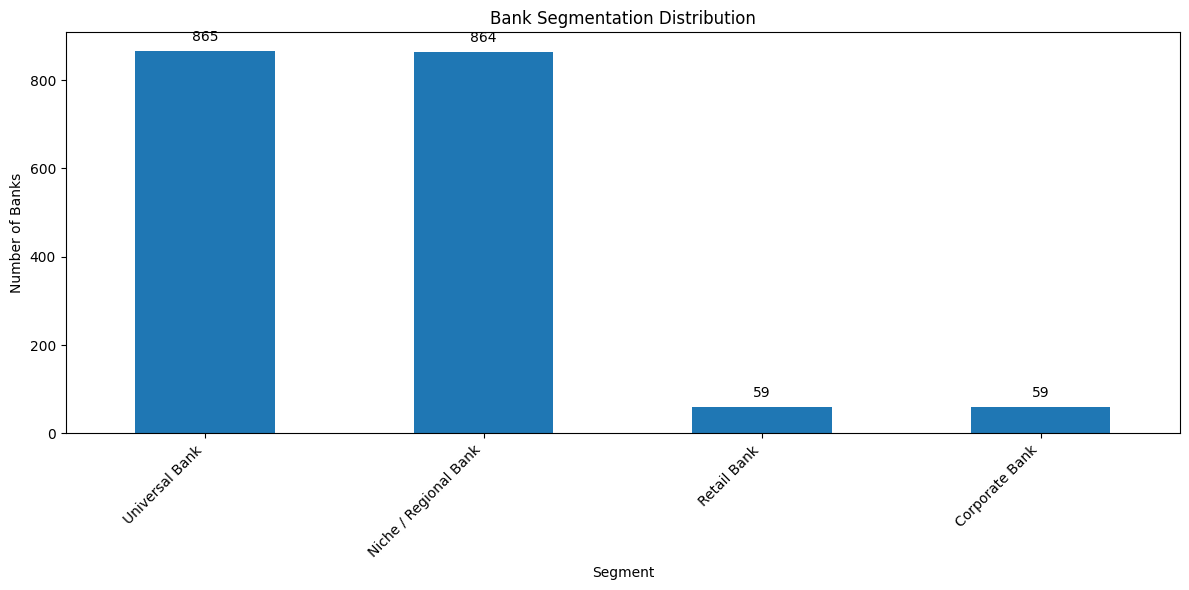

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


counts = segmentation["bank_segment"].value_counts()

ax = counts.plot(kind="bar", figsize=(12, 6))
plt.title("Bank Segmentation Distribution")
plt.xlabel("Segment")
plt.ylabel("Number of Banks")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10,
                xytext=(0, 5),
                textcoords='offset points')

plt.show()

In [ ]:


top_10_share = market_share["remitter_share_%"].head(10).sum()


print("Top 10 banks contribute {:.2f}% of total remitter value".format(top_10_share))
print("HHI (Concentration Risk):", round(HHI, 4))
print("\nBank Segmentation Count:")
print(segmentation["bank_segment"].value_counts())

Top 10 banks contribute 74.95% of total remitter value
HHI (Concentration Risk): 0.1004

Bank Segmentation Count:
bank_segment
Universal Bank           865
Niche / Regional Bank    864
Retail Bank               59
Corporate Bank            59
Name: count, dtype: int64
